In [3]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
#suppressMessages(library(xts))
suppressMessages(library(forecast))

# Marriages Prediction

the data is fairly simple. Its the monthly number of transactions from 2010 to 2016. URL: https://data.qld.gov.au/dataset/marriages-by-month

1. Merge the data
2. Exploratory Analysis
3. Model Selection
4. Evaluate

# 1) Merge Dataset

In [4]:
df2016 <- read.csv('Marriages2016.csv')
df2015 <- read.csv('Marriages2015.csv')
df2014 <- read.csv('Marriages2014.csv')
df2013 <- read.csv('Marriages2013.csv')
df2012 <- read.csv('Marriages2012.csv')
df2011 <- read.csv('Marriages2011.csv')
df2010 <- read.csv('Marriages2010.csv')

In [5]:
df2016 <- cbind(year=2016,df2016)
df2015 <- cbind(year=2015,df2015)
df2014 <- cbind(year=2014,df2014)
df2013 <- cbind(year=2013,df2013)
df2012 <- cbind(year=2012,df2012)
df2012<- df2012[1:12,]
df2011 <- cbind(year=2011,df2011)
df2010 <- cbind(year=2010,df2010)

In [6]:
df2012

year,Month,Transactions
2012,1,1232
2012,2,1334
2012,3,2370
2012,4,2292
2012,5,2169
2012,6,1937
2012,7,1441
2012,8,2041
2012,9,3762
2012,10,3016


In [7]:
df <- do.call("rbind", list(df2010,df2011,df2012, df2013, df2014,df2015,df2016))

In [8]:
mts <- ts(df$Transactions, start = c(2010, 1), frequency=12)

# 2) Exploring and Analysing the data

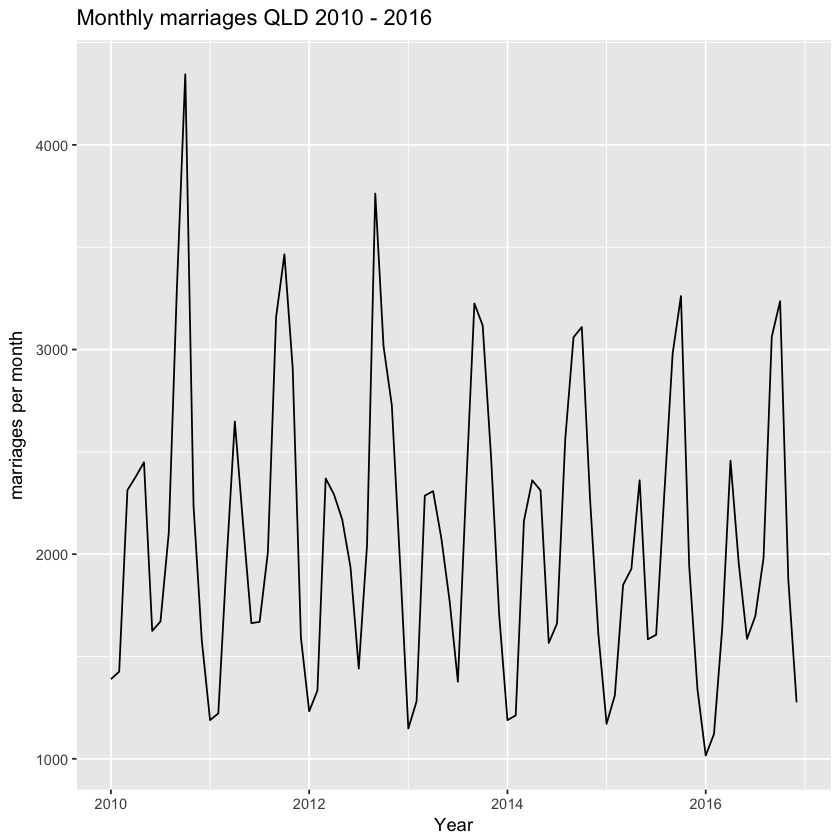

In [17]:
autoplot(mts) +
  ggtitle("Monthly marriages QLD 2010 - 2016") +
  ylab("marriages per month") + xlab("Year")

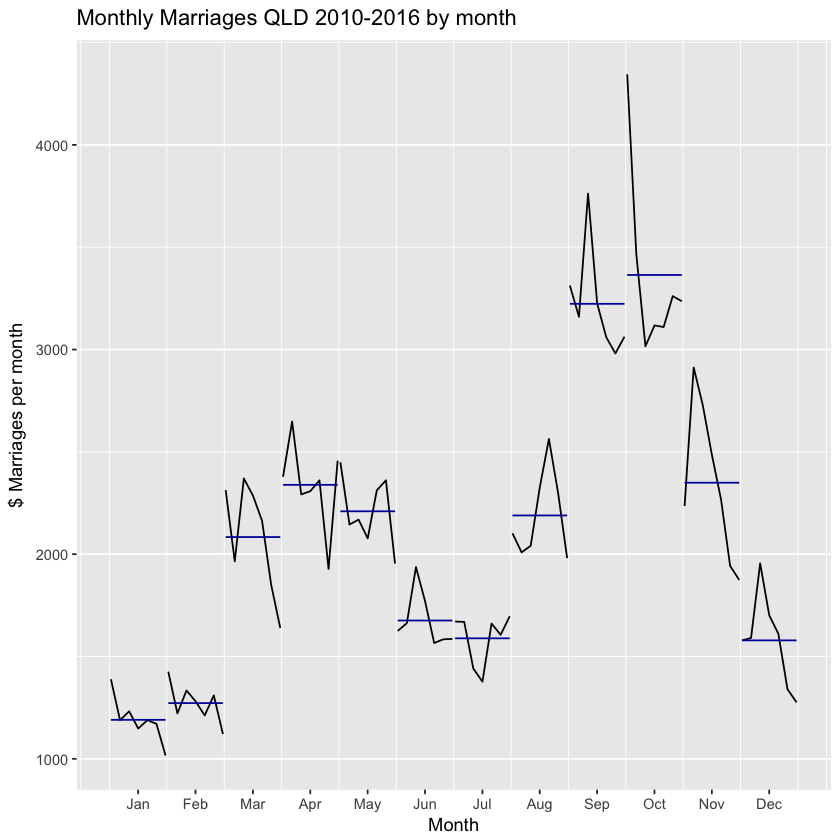

In [20]:
ggsubseriesplot(mts) + ylab("$ Marriages per month") +
  ggtitle("Monthly Marriages QLD 2010-2016 by month")

We can see that our time series has seasonality and a slight downward trend. 

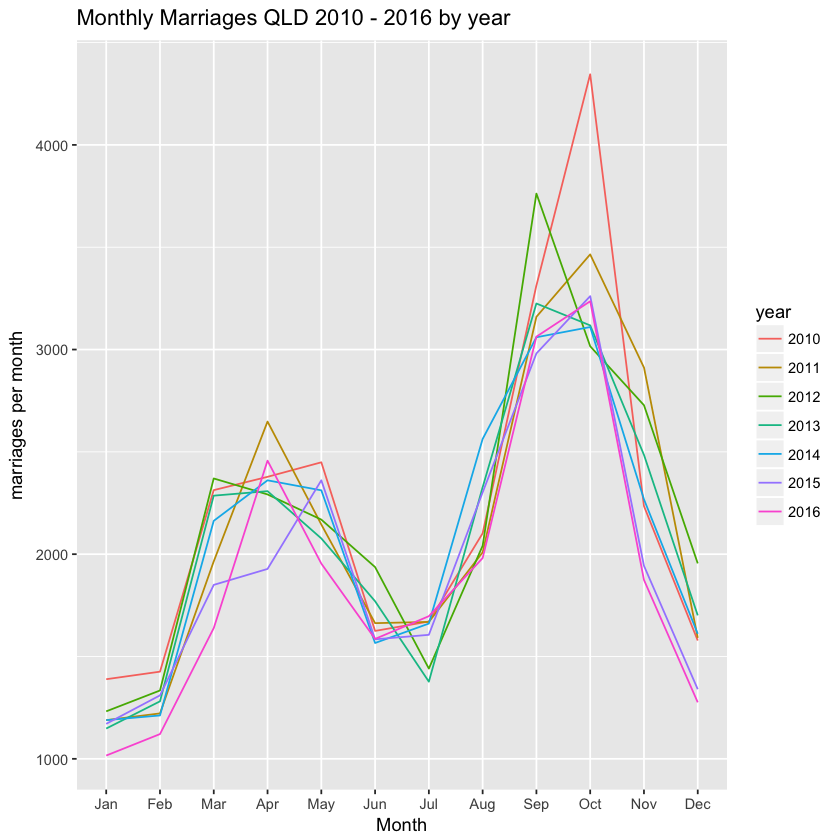

In [21]:
ggseasonplot(mts) + ggtitle("Monthly Marriages QLD 2010 - 2016 by year") + ylab("marriages per month")

### Time series decomposition 

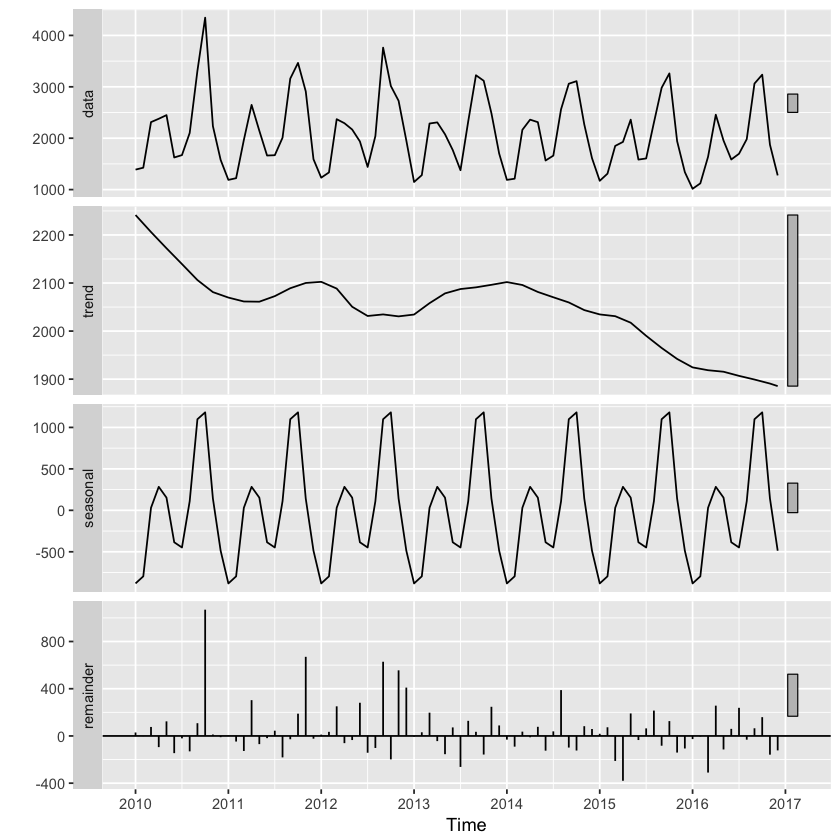

In [13]:
autoplot(stl(mts, s.window="periodic", robust=TRUE))

# 3) Model Selection

In [24]:
train <- window(mts, 2010, c(2015, 12))
test <- window(mts, 2016, c(2016, 12))

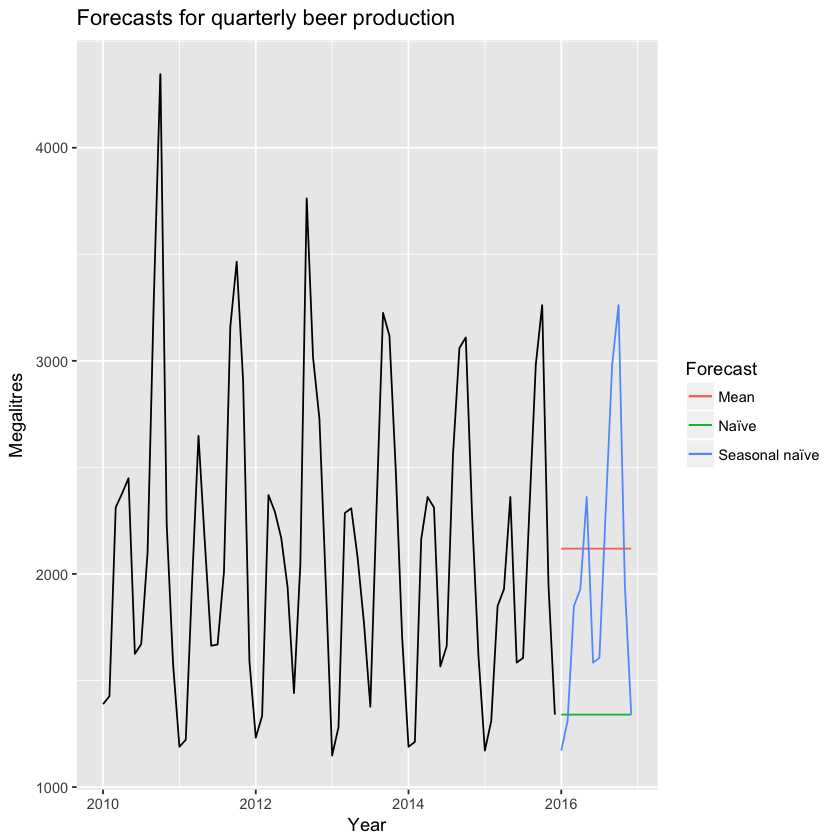

In [25]:
autoplot(train) +
  forecast::autolayer(meanf(train, h=12)$mean, series="Mean") +
  forecast::autolayer(naive(train, h=12)$mean, series="Naïve") +
  forecast::autolayer(snaive(train, h=12)$mean, series="Seasonal naïve") +
  ggtitle("Forecasts for quarterly beer production") +
  xlab("Year") + ylab("Megalitres") +
  guides(colour=guide_legend(title="Forecast"))

In [26]:
fit.sn <- snaive(train,h=12)

In [29]:
accuracy(forecast(fit.sn,h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


RMSE of 237.57 will be the base line error that we will try to improve upon.

In [30]:
res <- residuals(fit.sn)

In [33]:
Box.test(res, lag=12, fitdf=4, type="Ljung")


	Box-Ljung test

data:  res
X-squared = 18.063, df = 8, p-value = 0.02076


In [34]:
e <- tsCV(mts, rwf, drift=TRUE, h=1)

In [35]:
sqrt(mean(e^2, na.rm=TRUE))

[1] 705.8944

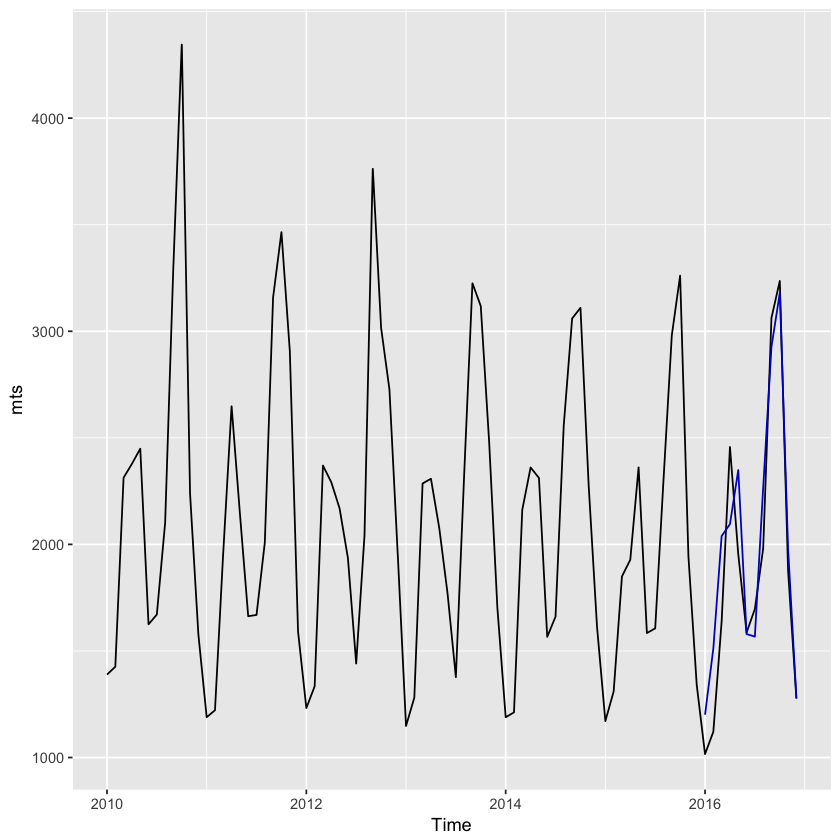

In [45]:
fit.nn <- nnetar(train, lambda=0)
autoplot(mts) + forecast::autolayer(forecast(fit.nn,h=12))

# ETS

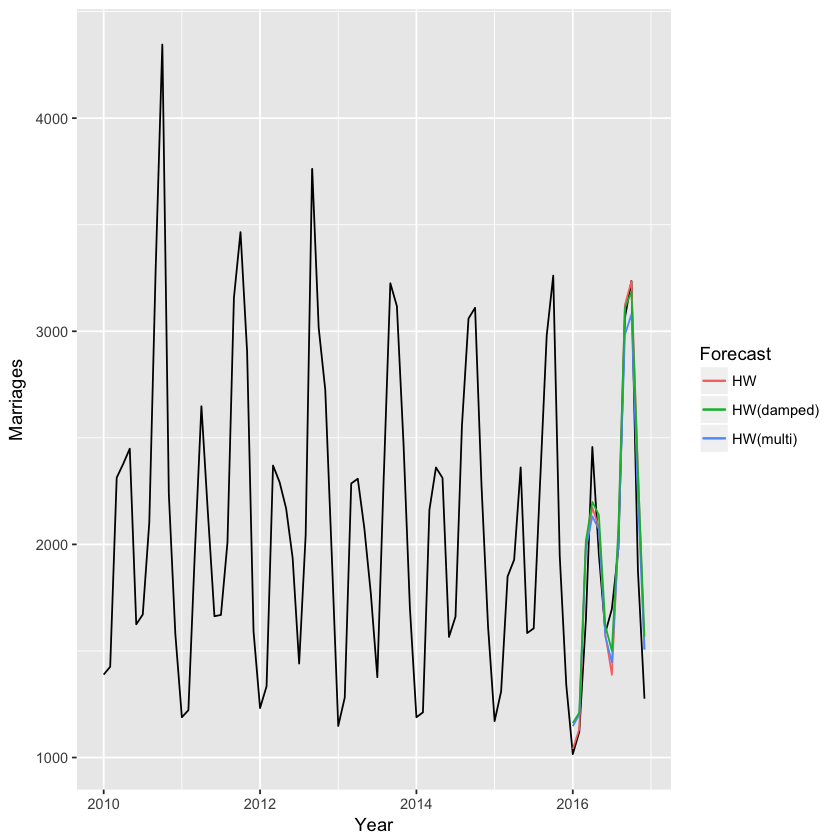

In [26]:
fit.ets1 <- hw(train,seasonal="additive",h=12)
fit.ets2 <- hw(train,seasonal="multiplicative",h=12)
fit.ets3 <- hw(train,damped=TRUE,seasonal="multiplicative",h=12)
autoplot(mts) +
  forecast::autolayer(fit.ets1$mean, series="HW") +
  forecast::autolayer(fit.ets2$mean, series="HW(multi)") +
  forecast::autolayer(fit.ets3$mean, series="HW(damped)") +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [89]:
fit.sn <- snaive(train,h=12)
fit.aa <- auto.arima(train)

In [104]:
accuracy(forecast(fit.nn,h=12)$mean, test)
accuracy(forecast(fit.ets1,h=12)$mean, test)
accuracy(forecast(fit.ets2,h=12)$mean, test)
accuracy(forecast(fit.ets3,h=12)$mean, test)
accuracy(forecast(fit.sn,h=12)$mean, test)
accuracy(forecast(fit, h=12)$mean, test)
accuracy(forecast(fit.aa, h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-89.23436,252.2252,204.231,-7.400304,12.22459,-0.330226,0.5792905


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.05745,223.8809,161.6909,-4.105219,9.170039,-0.1170756,0.4201511


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-101.9767,228.6859,186.162,-7.268896,11.20716,-0.1850818,0.4300565


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-82.34739,242.9205,189.7845,-6.636856,11.17488,-0.535255,0.4538611


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-19.70067,235.3983,174.6467,-3.019327,9.730234,-0.5024742,0.4386047


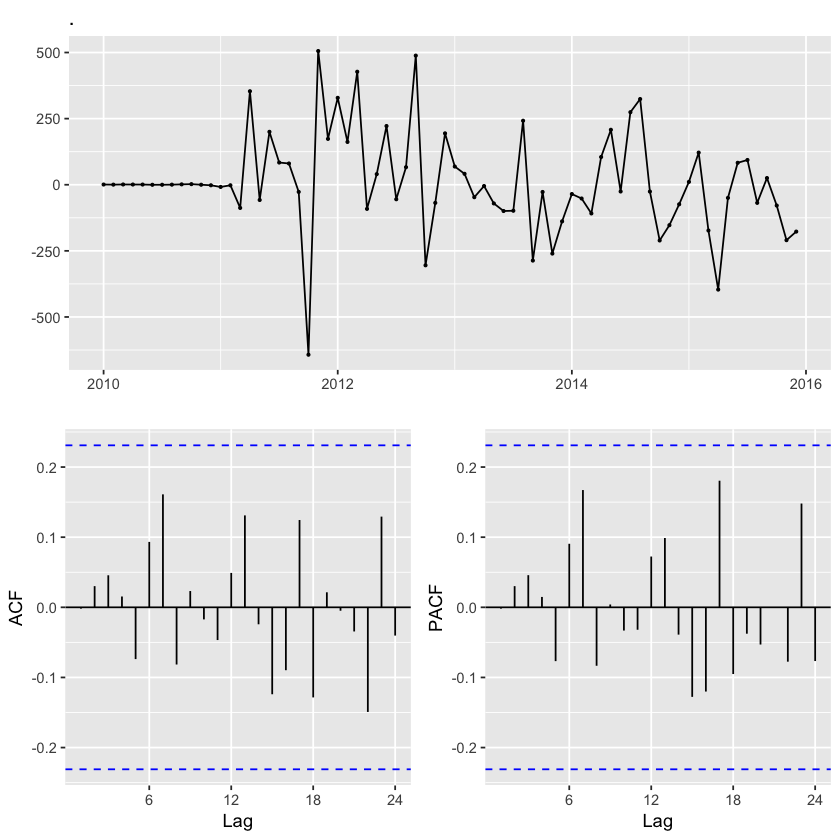

In [196]:
train %>%
  Arima(order=c(2,1,2), seasonal=c(3,1,1)) %>%
  residuals %>%
  ggtsdisplay

In [21]:
fit.arima1 <- Arima(train,order=c(2,1,3), seasonal=c(3,1,1))

In [27]:
fcast.arima <- forecast(fit.arima1, h=12)$mean
fcast.ets <- forecast(fit.ets2,h=12)$mean

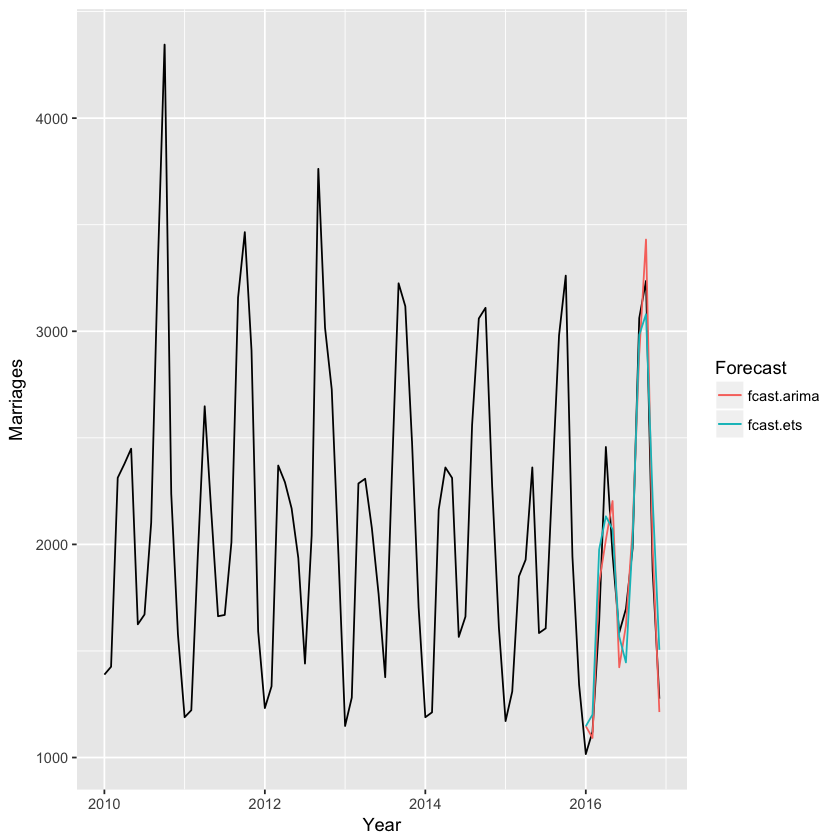

In [29]:
autoplot(mts) +
  forecast::autolayer(fcast.arima) +
  forecast::autolayer(fcast.ets) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [28]:
accuracy(fcast.arima, test)
accuracy(fcast.ets, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-1.697471,188.4264,157.6635,-0.632198,8.22714,-0.6236964,0.3392899


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003
